A/B test is a widely used experimental setup in numerous areas. In the experiment, the original population has been divided into two groups, called control and exposed groups (not necessarily the same size), respectively. The goal is to see if the exposed group exhibits any significant treatment effect. 

To test if the resutls from the control and exposed groups are different, several approaches can be used.

From a frequentist point of view, the most commonly used method is the hypothesis testing, in which we propose a null hypothesis stating that there is *no* difference between these two groups. We then actually calculate the test statistics and look up the corresponding p-value. If the p-value is small enough, say smaller than 5%, we then reject the null hypothesis.

One drawback (among numerous other drawbacks) with the above approach is that the methodology only tells us if there is difference or not. It does not say that, when the difference exists, how does the target variable depend on the treatment. 

We will use Bayesian approach to illustrate how to use MCMC to achieve the above goal.

In [7]:
import scipy.stats
import numpy as np
import pandas as pd

import pymc3 as pm
from bambi import Model

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

In [13]:
control_true_mean = 0.5
control_true_std = 0.1
exposed_true_mean = 0.57
exposed_true_std = 0.1

actua_diff = exposed_true_mean - control_true_mean

control_size = 50
exposed_size = 20

control_data = np.random.normal(loc=control_true_mean, scale=control_true_std, size=control_size)
exposed_data = np.random.normal(loc=exposed_true_mean, scale=exposed_true_std, size=exposed_size)

In [46]:
# Frequentist approach, hypothesis test:
scipy.stats.ttest_ind(control_data, exposed_data)

Ttest_indResult(statistic=-1.8214520243246193, pvalue=0.072936884050873604)

In [ ]:
# Bayesian approach, MCMC
control_df = pd.DataFrame({'score': control_data})
control_df['treatment'] = '0_control'

exposed_df = pd.DataFrame({'score': exposed_data})
exposed_df['treatment'] = '1_exposed'

data = pd.concat([control_df, exposed_df], axis=0).reset_index(drop=True)


model = Model(data)
results = model.fit('score ~ treatment', samples=3000)
results = results[1500:]

mcmc_trace = model.backend.trace


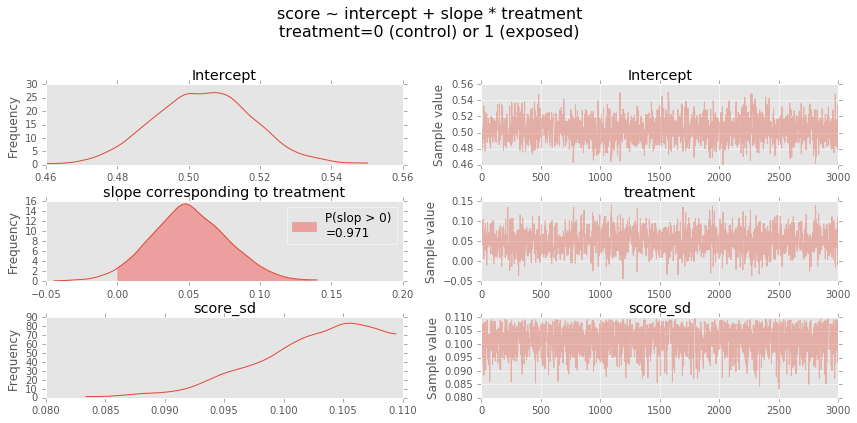

In [45]:
plt.close('all')
axes = pm.traceplot(mcmc_trace)

ax = axes[1][0]
ax.set_title('slope corresponding to treatment')
treatment_kde = scipy.stats.gaussian_kde(mcmc_trace['treatment'][:,0])
values = treatment_kde.pdf(np.linspace(0, 0.2))

treatment_values = mcmc_trace['treatment'][:,0]
prob_positive = treatment_values[treatment_values>0].size/treatment_values.size

ax.fill_between(np.linspace(0, 0.2), values, color='r', alpha=0.3, 
                label='P(slop > 0)\n={0:.3f}'.format(prob_positive))
ax.legend(loc='best')

fig = axes[0][0].figure
fig.subplots_adjust(top=0.79)
fig.suptitle('score ~ intercept + slope * treatment\ntreatment=0 (control) or 1 (exposed)', y=0.97, fontsize=16)

We use Bayesian regression to fit a simple linear model on the data that consists of both control and exposed examples. The above MCMC results show that there is a very high probability that the slope associated with the treatment is positive. Hence, we know that when treatment=exposed, it will contribute positively to the score variable.